# Medicamentos MUBICS

In [9]:
library(dplyr)
library(readxl)
#install.packages("class")
#install.packages("caret")
#install.packages("codetools")
library(class)
library(caret)
#Obtemos la base de datos original
dataset <- read_excel("dataset_Chembl_Cytokines.xlsx")
head(dataset, 4)


CMPD_CHEMBLID,CANONICAL_SMILES,PROTEIN_ACCESSION,STANDARD_TYPE_UNITSj,STANDARD_VALUE,ASSAY_ORGANISM,ORGANISM
CHEMBL117109,Fc1ccc(cc1)c2nc3ccccn3c2C4=NN(C(=O)C=C4)c5c(Cl)cccc5Cl,O15264,Inhibition (%),60,Homo sapiens,Homo sapiens
CHEMBL357732,Cc1ccccc1C(=O)c2ccc(Nc3ccccc3N)cc2,O15264,IC50 (nM),47,Homo sapiens,Homo sapiens
CHEMBL325597,CCCn1c(SC)nc(c2ccc(F)cc2)c1c3ccncc3,O15264,IC50 (nM),1300,Homo sapiens,Homo sapiens
CHEMBL94487,CC(C)(C)c1onc(NC(=O)Nc2ccc(Oc3ccccc3)cc2)c1,O15264,IC50 (nM),360,Escherichia coli,Homo sapiens


In [10]:
#Filtramos la base de datos para tener solo los valores referentes a IC50 y Homo Sapiens
medicamentos<- filter(dataset,dataset$STANDARD_TYPE_UNITSj=="IC50 (nM)")
medicamentos<- filter(medicamentos,medicamentos$ASSAY_ORGANISM=="Homo sapiens")
#Creamos un data frame con las columnas id, smiles y value
medicamentos <- data.frame("chemblid"= medicamentos$CMPD_CHEMBLID,
                           "smiles" = medicamentos$CANONICAL_SMILES,  "value" = medicamentos$STANDARD_VALUE)
head(medicamentos, 4)
#PONER COMENTADAS LAS LINEAS PARA OBTENER LOS MARCADORES

chemblid,smiles,value
CHEMBL357732,Cc1ccccc1C(=O)c2ccc(Nc3ccccc3N)cc2,47
CHEMBL325597,CCCn1c(SC)nc(c2ccc(F)cc2)c1c3ccncc3,1300
CHEMBL425494,COc1ccc(N2C(=O)Nc3c2ncnc3c4ccccc4C)c(OC)c1,5200
CHEMBL103667,Cc1ccc(cc1)n2nc(cc2NC(=O)Nc3ccc(OCCN4CCOCC4)c5ccccc35)C(C)(C)C,9


In [ ]:
#Obtenemos los SMILES y calculamos los descriptores
#smiles <- medicamentos$smiles
#vectorDescriptores <- data.frame()
#library(rcdk)
#for(i in 1:length(smiles)) {
#  anle138b = parse.smiles(as.vector(smiles[i]))
#  descriptors = get.desc.names(type="all")
#  descriptorsvalues = eval.desc(anle138b,descriptors)
#  vectorDescriptores <- rbind(vectorDescriptores,descriptorsvalues)
#}

In [2]:
#cargamos descriptores moleculares
vectorDescriptores <- read.csv("vectorDescriptores.csv")
#eliminamos columnas de nulos
vectorDescriptores <- Filter(function(x)!any(is.na(x)),vectorDescriptores)
#eliminas filas con valores nulos (2)
vectorDescriptores <- vectorDescriptores[complete.cases(vectorDescriptores),]
head(vectorDescriptores,4)

CanonicalSmiles,nSmallRings,nAromRings,nRingBlocks,nAromBlocks,nRings3,nRings4,nRings5,nRings6,nRings7,...,ATSm1,ATSm2,ATSm3,ATSm4,ATSm5,nAtom,nAromBond,naAromAtom,apol,nAcid
Cc1ccccc1C(=O)c2ccc(Nc3ccccc3N)cc2,3,3,3,3,0,0,0,3,0,...,24.49443,25.83064,35.66128,37.68544,31.32519,41,18,18,50.20427,0
CCCn1c(SC)nc(c2ccc(F)cc2)c1c3ccncc3,3,3,3,3,0,0,1,2,0,...,31.70974,30.08463,40.91373,44.00093,44.25296,41,17,17,50.43927,0
COc1ccc(N2C(=O)Nc3c2ncnc3c4ccccc4C)c(OC)c1,4,4,3,3,0,0,1,3,0,...,30.76333,33.15610,47.84469,53.59225,54.50528,45,22,21,54.00827,0
Cc1ccc(cc1)n2nc(cc2NC(=O)Nc3ccc(OCCN4CCOCC4)c5ccccc35)C(C)(C)C,5,4,4,3,0,0,1,4,0,...,43.12331,46.68226,66.81389,66.78627,64.72736,76,22,21,87.13734,0


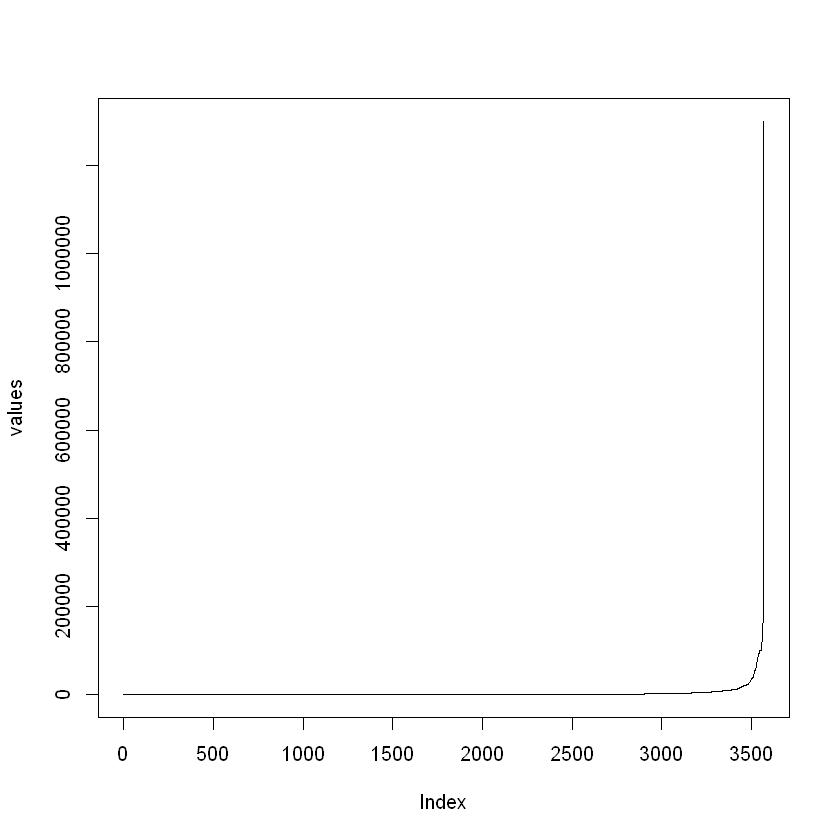

In [16]:
#Comprobemos la distribucion de los valores de IC50
values=sort(medicamentos$value)
plot(values,type="l")
options(repr.plot.width=4, repr.plot.height=4)

In [3]:
#Decidimos un punto de separacion entre valores IC50 altos (HIGH) y bajos (LOW)

median(values)
#Debido a la distribución de los datos la mediana no es fiable, ya que los valores se mantienen bajos
#hasta llegar al último 10% de los datos

ERROR: Error in median(values): objeto 'values' no encontrado


In [39]:
#La media se ajusta un poco más
mean(values)

[1] 3367,963

In [30]:
#También se puede escojer como punto de separación, el punto medio de la curva de crecimiento que se ve en
#la gráfica. La posición 3500 (aprox)
#values[3500]

In [52]:
#utilizamos la media como umbral para definir las clases IC50LOW (1) e IC50HIGH (0)
valorTeorico = 100 # <101 lo consideraremos IC50bajo
#tmp <- ifelse(medicamentos$value < mean(medicamentos$value), 1, 0)
vectorClase <- ifelse(medicamentos$value < valorTeorico, 1, 0)
vectorDescriptores$class <- vectorClase

smiles=vectorDescriptores$CanonicalSmiles
vectorDescriptores$CanonicalSmiles <- NULL
head(vectorDescriptores,4)

nSmallRings,nAromRings,nRingBlocks,nAromBlocks,nRings3,nRings4,nRings5,nRings6,nRings7,nRings8,...,ATSm2,ATSm3,ATSm4,ATSm5,nAtom,nAromBond,naAromAtom,apol,nAcid,class
3,3,3,3,0,0,0,3,0,0,...,25.83064,35.66128,37.68544,31.32519,41,18,18,50.20427,0,1
3,3,3,3,0,0,1,2,0,0,...,30.08463,40.91373,44.00093,44.25296,41,17,17,50.43927,0,0
4,4,3,3,0,0,1,3,0,0,...,33.15610,47.84469,53.59225,54.50528,45,22,21,54.00827,0,0
5,4,4,3,0,0,1,4,0,0,...,46.68226,66.81389,66.78627,64.72736,76,22,21,87.13734,0,1


In [86]:
#Clasificacion para knn
n = 10 #número de modelos para hacer la media
precisionMedia = 0
sensibilidadMedia = 0
especifidadMedia = 0
exactitudMedia = 0
for(i in 1:n) {
    #version cutre de división de grupos
    nEntrenamiento = round(0.8 * nrow(vectorDescriptores))
    entrenamiento<-sample(1:nrow(vectorDescriptores),nEntrenamiento)
    conjunto_entrenamiento<-vectorDescriptores[entrenamiento,]
    conjunto_test<-vectorDescriptores[-entrenamiento,]
    y = vectorClase[entrenamiento]
    #Clasificacion para knn
    prediccionTest <- knn(conjunto_entrenamiento,conjunto_test,cl=factor(y),k=7, l=0, prob=FALSE, use.all=TRUE)
    #vectorDescriptores$class <- vectorClase
    #Obtenemos las clases de los datos de entrenamiento
    validacionTest <- vectorClase[-entrenamiento]
    #caret::confusionMatrix(predicho, valoresReales)
    #tabla <- table(predicho, validacionTest)
    #tabla
    confmatrix <- caret::confusionMatrix(table(prediccionTest, validacionTest))
    precisionMedia = precisionMedia + confmatrix$overall[1]
    sensibilidadMedia = sensibilidadMedia + confmatrix$byClass[1]
    especifidadMedia = especifidadMedia + confmatrix$byClass[2]
    exactitudMedia = exactitudMedia + confmatrix$byClass[5]
}
confmatrix
round((precisionMedia/n),3) #precisión
round((sensibilidadMedia/n),3) #sensibilidad
round((especifidadMedia/n),3) #especifidad
round((exactitudMedia/n),3) #exactitud


Confusion Matrix and Statistics

              validacionTest
prediccionTest   0   1
             0 246 108
             1 115 245
                                          
               Accuracy : 0.6877          
                 95% CI : (0.6523, 0.7215)
    No Information Rate : 0.5056          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.3754          
                                          
 Mcnemar's Test P-Value : 0.6878          
                                          
            Sensitivity : 0.6814          
            Specificity : 0.6941          
         Pos Pred Value : 0.6949          
         Neg Pred Value : 0.6806          
             Prevalence : 0.5056          
         Detection Rate : 0.3445          
   Detection Prevalence : 0.4958          
      Balanced Accuracy : 0.6877          
                                          
       'Positive' Class : 0               
         

Accuracy 
   0.704

Sensitivity 
      0.699

Specificity 
       0.71

Precision 
    0.703